# Model Evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt 
import matplotlib as mpl

import DataManagement.DataRetrieval as ext
import DataManagement.DataSelection as ed
import importlib
import warnings

from RuntimePrediction.Predict import Predictor as P
from RuntimePrediction.Predict import OptimisticModel as OM, SimilarityModel as PM
warnings.filterwarnings("ignore")

In [2]:
#extracted_df = ext.get_experiments(download_new=True)
#extracted_df.to_csv('full_df.tsv', sep='\t', index=False)

In [3]:
full_df = pd.read_csv('full_df.tsv', sep='\t')
full_df.loc[:, 'args'] = full_df['args'].astype('str').map(lambda s: eval(s) if s and s !='nan' else [])

In [4]:
df = ed.prune(full_df)   # Only take successful data analytics tasks
df = ed.transform(df)  # Add info, such as total available memory, cash spent, data size

In [5]:
ff = 'DejaVu Serif'
#ff = 'DejaVu Sans'
mpl.rc('font', family=ff)

## Available Datapoints

In [6]:
xs, os, ps, rs, ns = {}, {}, {} , {}, {}

In [7]:
def routine1(X, y, name, iter1, iter2):
    training_sizes = np.arange(5,len(y), int(0.05 * len(y)))
    xs_, os_, ps_, rs_, ns_ = [], [], [], [], []
    for i, ts in enumerate(training_sizes):
        model = P()
        e, _ = model.eval(X, y, train_size=ts, duplicate_ratio=0,
                          iterations=(20-i)*iter1+iter2, use_mre=True)
        xs_.append(ts)
        os_.append(e['Optimistic Model v1'])
        ps_.append(e['Pessimistic Model v1'])
        rs_.append(e['Reference Model (LR)'])
        ns_.append(e['Null Regressor'])

    xs[name] = xs_
    os[name] = os_
    ps[name] = ps_
    rs[name] = rs_
    ns[name] = ns_

In [8]:
sort_df = ed.select_algorithm(df, 'Sort')
sort_df = sort_df[sort_df['data_size'] > 7000]  # filter some testruns for m4.2xl
sort_df = sort_df[sort_df['machine_type'] == 'c4.2xlarge']

X, y = ed.get_training_data(sort_df)

routine1(X, y, 'Sort', 100, 200)

In [9]:
grep_df = ed.select_algorithm(df, 'Grep')
grep_df = grep_df[grep_df['machine_type'] == 'm4.2xlarge']

X, y = ed.get_training_data(grep_df)

routine1(X, y, 'Grep', 200, 400)

In [10]:
sgd_df = ed.select_algorithm(df, 'SGDLR')
sgd_df = sgd_df[sgd_df['machine_type'] == 'r4.2xlarge']
sgd_df = sgd_df[sgd_df['instance_count'] > 2]

X, y = ed.get_training_data(sgd_df)

routine1(X, y, 'SGD', 100, 200)

In [11]:
km_df = ed.select_algorithm(df, 'KMeans')
km_df = km_df[km_df['machine_type'] == 'r4.2xlarge']
km_df = km_df[km_df['instance_count'] > 2]

X, y = ed.get_training_data(km_df)

routine1(X, y, 'K-Means', 100, 200)

In [12]:
pr_df = ed.select_algorithm(df, 'PageRank')
pr_df = pr_df[pr_df['machine_type'] == 'r4.2xlarge']

X, y = ed.get_training_data(pr_df)

routine1(X, y, 'PageRank', 100, 200)

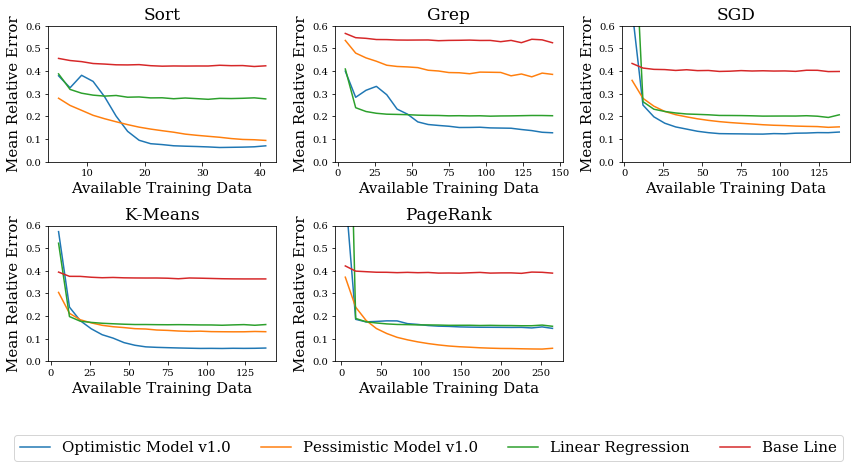

In [75]:
plt.figure(figsize=(12,8))
#plt.figure(figsize=(12,12))

lines = []
names = ['Sort', 'Grep', 'SGD', 'K-Means', 'PageRank']
for i, name in enumerate(names):
    
    plt.subplot(3,3,i+1)
    #plt.subplot(3,2,i+1)
    plt.title(name, fontsize=17)
    line1 = plt.plot(xs[name], os[name], '-', label='O')
    line2 = plt.plot(xs[name], ps[name], '-', label='P')
    line3 = plt.plot(xs[name], rs[name], '-', label='R')
    line4 = plt.plot(xs[name], ns[name], '-', label='N')
    if i == 0:
        lines += line1; lines += line2; lines += line3; lines += line4
    
    plt.ylim(ymin=0, ymax=0.6)

    plt.xlabel('Available Training Data', fontsize=15)
    plt.ylabel('Mean Relative Error', fontsize=15)
plt.figlegend(lines, ['Optimistic Model v1.0', 'Pessimistic Model v1.0', 'Linear Regression', 'Base Line'], fontsize=15, loc='lower center', ncol=4, bbox_to_anchor=[0.5, +.18], 
              bbox_transform=plt.gcf().transFigure)
#plt.figlegend(lines, ['Optimistic Model v1.0', 'Pessimistic Model v1.0', 'Linear Regression', 'Base Line Regressor'], fontsize=15, loc='lower center', ncol=1, bbox_to_anchor=[0.8, +.08], 

plt.tight_layout()
plt.savefig('figures/datapoints2x3.pdf', bbox_inches='tight')
#plt.savefig('figures/datapoints3x2.pdf', bbox_inches='tight')
plt.show()

## Recurring Jobs

In [14]:
xs2, os2, ps2, rs2, ns2 = {}, {}, {} , {}, {}

In [15]:
def routine2(X, y, name, iter1, iter2):
    xs_, os_, ps_, rs_, ns_ = [], [], [], [], []
    duplicate_ratios = np.arange(0.1, 0.8, 0.05)
    for i, dup in enumerate(duplicate_ratios):
        model = P()
        e, _ = model.eval(X, y, train_size=0.9, duplicate_ratio=dup,
                          iterations=(20-i)*iter1+iter2, use_mre=True)
        xs_.append(dup)
        os_.append(e['Optimistic Model v1'])
        ps_.append(e['Pessimistic Model v1'])
        rs_.append(e['Reference Model (LR)'])
        ns_.append(e['Null Regressor'])

    xs2[name] = xs_
    os2[name] = os_
    ps2[name] = ps_
    rs2[name] = rs_
    ns2[name] = ns_

In [16]:
sort_df = ed.select_algorithm(df, 'Sort')
sort_df = sort_df[sort_df['data_size'] > 7000]  # filter some testruns for m4.2xl
sort_df = sort_df[sort_df['machine_type'] == 'c4.2xlarge']
X, y = ed.get_training_data(sort_df)

routine2(X, y, 'Sort', 100, 200)

In [17]:
grep_df = ed.select_algorithm(df, 'Grep')
grep_df = grep_df[grep_df['machine_type'] == 'm4.2xlarge']
X, y = ed.get_training_data(grep_df)

routine2(X, y, 'Grep', 200, 400)

In [18]:
sgd_df = ed.select_algorithm(df, 'SGDLR')
sgd_df = sgd_df[sgd_df['instance_count'] > 2]
sgd_df = sgd_df[sgd_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(sgd_df)

routine2(X, y, 'SGD', 100, 200)

In [19]:
km_df = ed.select_algorithm(df, 'KMeans')
km_df = km_df[km_df['instance_count'] > 2]
km_df = km_df[km_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(km_df)

routine2(X, y, 'K-Means', 100, 200)

In [20]:
pr_df = ed.select_algorithm(df, 'PageRank')
pr_df = pr_df[pr_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(pr_df)

routine2(X, y, 'PageRank', 100, 200)

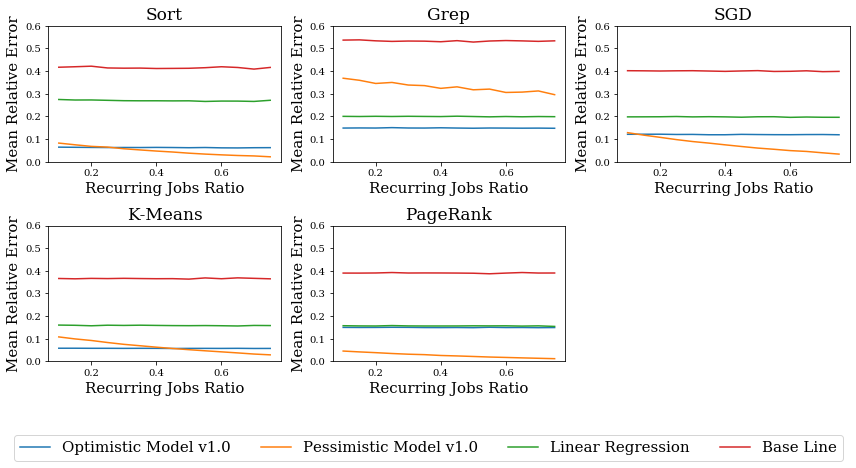

In [21]:
plt.figure(figsize=(12,8))

lines = []
names = ['Sort', 'Grep', 'SGD', 'K-Means', 'PageRank']
for i, name in enumerate(names):
    
    plt.subplot(3,3,i+1)
    plt.title(name, fontsize=17)
    line1 = plt.plot(xs2[name], os2[name], '-', label='O')
    line2 = plt.plot(xs2[name], ps2[name], '-', label='P')
    line3 = plt.plot(xs2[name], rs2[name], '-', label='R')
    line4 = plt.plot(xs2[name], ns2[name], '-', label='N')
    if i == 0:
        lines += line1; lines += line2; lines += line3; lines += line4
    
    plt.ylim(ymin=0, ymax=0.6)

    plt.xlabel('Recurring Jobs Ratio', fontsize=15)
    plt.ylabel('Mean Relative Error', fontsize=15)
plt.figlegend(lines, ['Optimistic Model v1.0', 'Pessimistic Model v1.0', 'Linear Regression', 'Base Line'], fontsize=15, loc='lower center', ncol=4, bbox_to_anchor=[0.5, +.18], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('figures/duplicates2x3.pdf', bbox_inches='tight')
plt.show()

## Dynamic Switcher

In [22]:
xs3, os3, ps3, rs3, ns3 = {}, {}, {} , {}, {}

In [23]:
def routine3(X, y, name, iter1, iter2):
    xs_, os_, ps_, rs_, ns_ = [], [], [], [], []
    training_sizes = np.arange(5,len(y), int(0.05 * len(y)))
    for i, ts in enumerate(training_sizes):
        model = P()
        e, _ = model.eval(X, y, train_size=ts, duplicate_ratio=0,
                          iterations=(20-i)*iter1+iter2, use_mre=True,
                          eval_switcher=True)
        xs_.append(ts)
        os_.append(e['Optimistic Model v1'])
        ps_.append(e['Pessimistic Model v1'])
        rs_.append(e['Reference Model (LR)'])
        ns_.append(e['C3O Predictor'])

    xs3[name] = xs_
    os3[name] = os_
    ps3[name] = ps_
    rs3[name] = rs_
    ns3[name] = ns_

In [24]:
sort_df = ed.select_algorithm(df, 'Sort')
sort_df = sort_df[sort_df['data_size'] > 7000]  # filter some testruns for m4.2xl
sort_df = sort_df[sort_df['machine_type'] == 'c4.2xlarge']
X, y = ed.get_training_data(sort_df)

routine3(X, y, 'Sort', 50, 100)

In [25]:
grep_df = ed.select_algorithm(df, 'Grep')
grep_df = grep_df[grep_df['machine_type'] == 'm4.2xlarge']
X, y = ed.get_training_data(grep_df)

routine3(X, y, 'Grep', 100, 200)  # took 4-5h

In [27]:
sgd_df = ed.select_algorithm(df, 'SGDLR')
sgd_df = sgd_df[sgd_df['instance_count'] > 2]
sgd_df = sgd_df[sgd_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(sgd_df)

routine3(X, y, 'SGD', 30, 50)

In [28]:
km_df = ed.select_algorithm(df, 'KMeans')
km_df = km_df[km_df['instance_count'] > 2]
km_df = km_df[km_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(km_df)

routine3(X, y, 'K-Means', 30, 50)

In [29]:
pr_df = ed.select_algorithm(df, 'PageRank')
pr_df = pr_df[pr_df['machine_type'] == 'r4.2xlarge']
X, y = ed.get_training_data(pr_df)

routine3(X, y, 'PageRank', 30, 50)

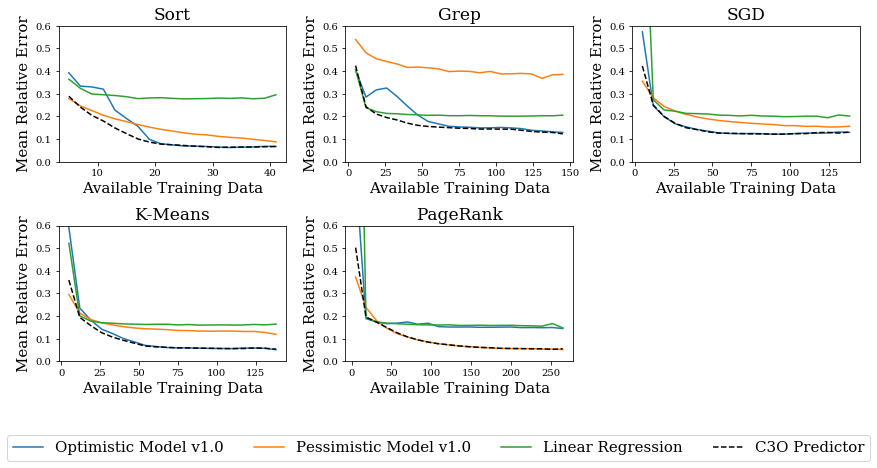

In [77]:
plt.figure(figsize=(12,8))

lines = []
names = ['Sort', 'Grep', 'SGD', 'K-Means', 'PageRank']
for i, name in enumerate(names):
    
    plt.subplot(3,3,i+1)
    plt.title(name, fontsize=17)
    line1 = plt.plot(xs3[name], os3[name], '-', label='O')
    line2 = plt.plot(xs3[name], ps3[name], '-', label='P')
    line3 = plt.plot(xs3[name], rs3[name], '-', label='R')
    line4 = plt.plot(xs3[name], ns3[name], '--', label='N', color='black')
    if i == 0:
        lines += line1; lines += line2; lines += line3; lines += line4
    
    plt.ylim(ymin=0, ymax=0.6)

    plt.xlabel('Available Training Data', fontsize=15)
    plt.ylabel('Mean Relative Error', fontsize=15)
plt.figlegend(lines, ['Optimistic Model v1.0', 'Pessimistic Model v1.0', 'Linear Regression', 'C3O Predictor'], fontsize=15, loc='lower center', ncol=4, bbox_to_anchor=[0.5, +.18], 
              bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.savefig('figures/switcher2x3.pdf', bbox_inches='tight')
plt.show()

## C3O Predictor

In [110]:
from sklearn.model_selection import train_test_split as tts

def mre(y_true, y_pred):  # Mean relative error
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))


# Eval C3O predictor, different training dataset sizes, different duplicate ratios
def routine4(xdf, train, dup, iterations):
    X, y = ed.get_training_data(xdf)
    mres = []
    for i in range(iterations):
        if dup:
            X_dup, _, y_dup, __ = tts(X ,y ,train_size=dup)
            X_copy, y_copy = np.append(X, X_dup, axis=0), np.append(y, y_dup, axis=0)
        else:
            X_copy, y_copy = X[:,:], y[:]
            
        X_train, X_test, y_train, y_test = tts(X_copy, y_copy, train_size=train)
        model = P()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mres.append(mre(y_test, y_pred))
    return sum(mres)/len(mres)

In [135]:
algos = (sort_df, grep_df, sgd_df, km_df, pr_df)
names = ('Sort', 'Grep', 'SGD', 'K-Means', 'PageRank')

print(f"40 TDP, 0% rec.\n{'-'*20}")
for i in range(0,5):
    print(f"{names[i]}: {routine4(algos[i], 40, 0, 500)}")
    
print(f"\n100 TDP, 0% rec.\n{'-'*20}")
for i in range(1,5):
    print(f"{names[i]}: {routine4(algos[i], 100, 0, 500)}")
    
print(f"\n100 TDP, 30% rec.\n{'-'*20}")
for i in range(1,5):
    print(f"{names[i]}: {routine4(algos[i], 100, .3, 500)}")

40 TDP, 0% rec.
--------------------
Sort: 0.0662222649558403
Grep: 0.17298019190918246
SGD: 0.14190375135771346
K-Means: 0.09151127281248345
PageRank: 0.15950979809505175

100 TDP, 0% rec.
--------------------
Grep: 0.14390258342621579
SGD: 0.12365705363374935
K-Means: 0.057264679174924615
PageRank: 0.08307910528175384

100 TDP, 30% rec.
--------------------
Grep: 0.14577451235086933
SGD: 0.1229961536487468
K-Means: 0.06202855523089467
PageRank: 0.07522074343838356


In [136]:
print(f"\n100 TDP, 60% rec.\n{'-'*20}")
for i in range(1,5):
    print(f"{names[i]}: {routine4(algos[i], 100, .6, 500)}")


100 TDP, 60% rec.
--------------------
Grep: 0.1434683849797585
SGD: 0.11307590282663445
K-Means: 0.06240602237157512
PageRank: 0.07438414626206363
